In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from qiskit_optimization import QuadraticProgram

# Creating synthetic data for P2P energy training

In [5]:
samples = np.random.normal(loc=11.5, scale=4.7, size=15000)

hours = np.arange(24)
min_value = 10
max_value = 123

participants_dict_per_hourdict={}
for hour in hours:
    participants_dict_per_hourdict[f"{hour}"] = 0
    for sample in samples:
        if np.abs(sample - hour)<.5:
              participants_dict_per_hourdict[f"{hour}"]+=1 
participants_by_hour = np.asarray(list(participants_dict_per_hourdict.values()))
participants_by_hour = participants_by_hour/np.max(participants_by_hour) * max_value

#either we set the values below min_value to min_value or throw it a away
#participants_by_hour[participants_by_hour<min_value] = 0
#participants_by_hour = np.clip(participants_by_hour/np.max(participants_by_hour) * max_value, a_min=min_value, a_max=max_value)

columns = ['Hour', 'Participant', 'Type', 'Price (cents/KWh)', 'Quantity (KW)']
df = pd.DataFrame(columns=columns)

# Generate bids and asks for each hour
for hour in hours:
    #print(hour)
    participants_by_hour[hour]=int(participants_by_hour[hour])
    if participants_by_hour[hour]%2!=0:
        participants_by_hour[hour]-=1
    print(f"hour:{hour}",participants_by_hour[hour])
    num_prosumers = int(participants_by_hour[hour]/2)
    num_consumers = int(participants_by_hour[hour] - num_prosumers)


    if participants_by_hour[hour] > 9:
    # Generate prosumer bids
        prosumer_bids = pd.DataFrame({
            'Hour': hour,
            'Participant': np.arange(num_prosumers),
            'Type': 'Bid',
            'Price (cents/KWh)': np.random.randint(8, 33, size=num_prosumers),
            'Quantity (KW)': np.random.randint(1, 6, size=num_prosumers)
        })

    # Generate consumer asks
        consumer_asks = pd.DataFrame({
            'Hour': hour,
            'Participant': np.arange(num_prosumers, num_prosumers + num_consumers),
            'Type': 'Ask',
            'Price (cents/KWh)': np.random.randint(8, 33, size=num_consumers),
            'Quantity (KW)': np.random.randint(5, 11, size=num_consumers)
        })
    else:
        # Generate prosumer bids
        prosumer_bids = pd.DataFrame({
            'Hour': hour,
            'Participant': [None],
            'Type': 'Bid',
            'Price (cents/KWh)': 0,
            'Quantity (KW)': 0
        })

    # Generate consumer asks
        consumer_asks = pd.DataFrame({
            'Hour': hour,
            'Participant': [None],
            'Type': 'Ask',
            'Price (cents/KWh)': 0,
            'Quantity (KW)': 0
        })
    

    # Concatenate prosumer bids and consumer asks
    hour_data = pd.concat([prosumer_bids, consumer_asks], ignore_index=True)

    # Add the generated data to the main DataFrame
    df = pd.concat([df, hour_data], ignore_index=True)

    df["Participant"]
# Sort the DataFrame based on hour and participant
df.sort_values(by=['Hour', 'Participant'], inplace=True, ignore_index=True)

hour:0 6.0
hour:1 8.0
hour:2 16.0
hour:3 24.0
hour:4 32.0
hour:5 46.0
hour:6 58.0
hour:7 76.0
hour:8 90.0
hour:9 104.0
hour:10 112.0
hour:11 118.0
hour:12 122.0
hour:13 112.0
hour:14 100.0
hour:15 92.0
hour:16 76.0
hour:17 64.0
hour:18 46.0
hour:19 34.0
hour:20 22.0
hour:21 14.0
hour:22 10.0
hour:23 4.0


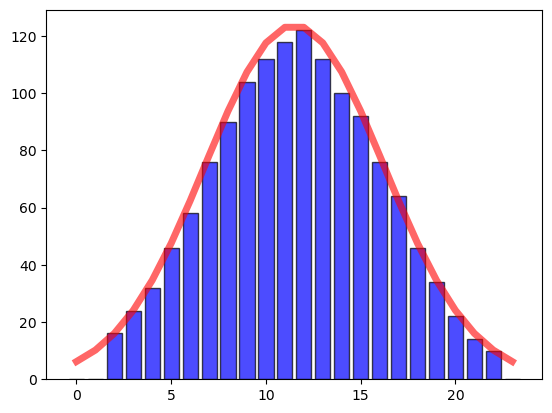

In [6]:
#comparing to exact distribution
#also cutting the cases when participants are below 10
x = np.linspace(0,23,24)

df_length_per_hour = df.groupby('Hour').size()
df_length_per_hour[df_length_per_hour<10] = 0
plt.bar(df_length_per_hour.index, df_length_per_hour.values, color='blue', alpha=0.7,edgecolor='black')
plt.plot(hours,123* norm.pdf(x, loc = 11.5, scale = 4.7)/max(norm.pdf(x, loc = 11.5, scale = 4.7)),
       'r-', lw=5, alpha=0.6, label='norm pdf')

# Creating QUBO

The cost function in the original formulation

$\max\limits_{x_{ij}} \sum\limits_{i=1}^{C}\sum\limits_{j=1}^{P} x_{ij}(p_i-p_j){\text{min}}\{Q_i,Q_j\}$

Subject to

$\sum\limits_{i}^C x_{ij}{\text{min}}\{Q_i,Q_j\}\leq Q_j$


$\sum\limits_{j}^P x_{ij}{\text{min}}\{Q_i,Q_j\}\leq Q_i$

In [8]:
#creating the Quadratic program
mod = QuadraticProgram("ET")
print(mod.prettyprint())

Problem name: ET

Minimize
  0

Subject to
  No constraints

  No variables



As of yet we are going to fill this up with the bids and asks from a given time interval, e.g. 2.

In [9]:
for i in range(int(len(df[df["Hour"]==2])/2)): #consumers
    for j in range(int(len(df[df["Hour"]==2])/2),int(len(df[df["Hour"]==2]))): #prosumers
        mod.binary_var(name=f"x_{int(i)}_{int(j)}")
print(mod.prettyprint())

Problem name: ET

Minimize
  0

Subject to
  No constraints

  Binary variables (64)
    x_0_8 x_0_9 x_0_10 x_0_11 x_0_12 x_0_13 x_0_14 x_0_15 x_1_8 x_1_9 x_1_10
    x_1_11 x_1_12 x_1_13 x_1_14 x_1_15 x_2_8 x_2_9 x_2_10 x_2_11 x_2_12 x_2_13
    x_2_14 x_2_15 x_3_8 x_3_9 x_3_10 x_3_11 x_3_12 x_3_13 x_3_14 x_3_15 x_4_8
    x_4_9 x_4_10 x_4_11 x_4_12 x_4_13 x_4_14 x_4_15 x_5_8 x_5_9 x_5_10 x_5_11
    x_5_12 x_5_13 x_5_14 x_5_15 x_6_8 x_6_9 x_6_10 x_6_11 x_6_12 x_6_13 x_6_14
    x_6_15 x_7_8 x_7_9 x_7_10 x_7_11 x_7_12 x_7_13 x_7_14 x_7_15



Now we assign the cost function given above.

In [10]:
#creating the cost function
#cost
lind_dict={}

for i in range(int(len(df[df["Hour"]==2])/2)): #consumers
    for j in range(int(len(df[df["Hour"]==2])/2),int(len(df[df["Hour"]==2]))):
        lind_dict[f"x_{int(i)}_{int(j)}"]=df.loc[df["Hour"] == 2, "Price (cents/KWh)"].values[i]-df.loc[df["Hour"] == 2, "Price (cents/KWh)"].values[j]\
            *min(df.loc[df["Hour"] == 2, "Quantity (KW)"].values[i],df.loc[df["Hour"] == 2, "Quantity (KW)"].values[j])


In [14]:
lind_dict

{'x_0_8': -14,
 'x_0_9': -18,
 'x_0_10': -18,
 'x_0_11': -44,
 'x_0_12': -10,
 'x_0_13': -10,
 'x_0_14': -30,
 'x_0_15': -24,
 'x_1_8': -39,
 'x_1_9': -47,
 'x_1_10': -47,
 'x_1_11': -99,
 'x_1_12': -31,
 'x_1_13': -31,
 'x_1_14': -71,
 'x_1_15': -59,
 'x_2_8': -39,
 'x_2_9': -47,
 'x_2_10': -47,
 'x_2_11': -99,
 'x_2_12': -31,
 'x_2_13': -31,
 'x_2_14': -71,
 'x_2_15': -59,
 'x_3_8': -28,
 'x_3_9': -34,
 'x_3_10': -34,
 'x_3_11': -73,
 'x_3_12': -22,
 'x_3_13': -22,
 'x_3_14': -52,
 'x_3_15': -43,
 'x_4_8': 7,
 'x_4_9': 5,
 'x_4_10': 5,
 'x_4_11': -8,
 'x_4_12': 9,
 'x_4_13': 9,
 'x_4_14': -1,
 'x_4_15': 2,
 'x_5_8': 1,
 'x_5_9': -1,
 'x_5_10': -1,
 'x_5_11': -14,
 'x_5_12': 3,
 'x_5_13': 3,
 'x_5_14': -7,
 'x_5_15': -4,
 'x_6_8': -4,
 'x_6_9': -8,
 'x_6_10': -8,
 'x_6_11': -34,
 'x_6_12': 0,
 'x_6_13': 0,
 'x_6_14': -20,
 'x_6_15': -14,
 'x_7_8': 6,
 'x_7_9': 4,
 'x_7_10': 4,
 'x_7_11': -9,
 'x_7_12': 8,
 'x_7_13': 8,
 'x_7_14': -2,
 'x_7_15': 1}

In [11]:
mod.maximize(linear=lind_dict)
print(mod.prettyprint())

Problem name: ET

Maximize
  -18*x_0_10 - 44*x_0_11 - 10*x_0_12 - 10*x_0_13 - 30*x_0_14 - 24*x_0_15
  - 14*x_0_8 - 18*x_0_9 - 47*x_1_10 - 99*x_1_11 - 31*x_1_12 - 31*x_1_13
  - 71*x_1_14 - 59*x_1_15 - 39*x_1_8 - 47*x_1_9 - 47*x_2_10 - 99*x_2_11
  - 31*x_2_12 - 31*x_2_13 - 71*x_2_14 - 59*x_2_15 - 39*x_2_8 - 47*x_2_9
  - 34*x_3_10 - 73*x_3_11 - 22*x_3_12 - 22*x_3_13 - 52*x_3_14 - 43*x_3_15
  - 28*x_3_8 - 34*x_3_9 + 5*x_4_10 - 8*x_4_11 + 9*x_4_12 + 9*x_4_13 - x_4_14
  + 2*x_4_15 + 7*x_4_8 + 5*x_4_9 - x_5_10 - 14*x_5_11 + 3*x_5_12 + 3*x_5_13
  - 7*x_5_14 - 4*x_5_15 + x_5_8 - x_5_9 - 8*x_6_10 - 34*x_6_11 - 20*x_6_14
  - 14*x_6_15 - 4*x_6_8 - 8*x_6_9 + 4*x_7_10 - 9*x_7_11 + 8*x_7_12 + 8*x_7_13
  - 2*x_7_14 + x_7_15 + 6*x_7_8 + 4*x_7_9

Subject to
  No constraints

  Binary variables (64)
    x_0_8 x_0_9 x_0_10 x_0_11 x_0_12 x_0_13 x_0_14 x_0_15 x_1_8 x_1_9 x_1_10
    x_1_11 x_1_12 x_1_13 x_1_14 x_1_15 x_2_8 x_2_9 x_2_10 x_2_11 x_2_12 x_2_13
    x_2_14 x_2_15 x_3_8 x_3_9 x_3_10 x_3_11 x_3_12 x

We create the constraints given above.

In [12]:
#constraint consumers
constraints_consumer={}
for i in range(int(len(df[df["Hour"]==2])/2)):
    constraints_consumer[f"consumer_ID_{i}"] = {}
    for j in range(int(len(df[df["Hour"]==2])/2),int(len(df[df["Hour"]==2]))):
        constraints_consumer[f"consumer_ID_{i}"][f"x_{i}_{j}"] = min(df.loc[df["Hour"] == 2, "Quantity (KW)"].values[i],df.loc[df["Hour"] == 2, "Quantity (KW)"].values[j])

#constraint prosumers
constraints_prosumer={}
for j in range(int(len(df[df["Hour"]==2])/2),int(len(df[df["Hour"]==2]))):
    constraints_prosumer[f"prosumer_ID_{j}"] = {}
    for i in range(int(len(df[df["Hour"]==2])/2)):
        constraints_prosumer[f"prosumer_ID_{j}"][f"x_{i}_{j}"] = min(df.loc[df["Hour"] == 2, "Quantity (KW)"].values[i],df.loc[df["Hour"] == 2, "Quantity (KW)"].values[j])


In [13]:
#this is a dictinary
constraints_consumer

{'consumer_ID_0': {'x_0_8': 2,
  'x_0_9': 2,
  'x_0_10': 2,
  'x_0_11': 2,
  'x_0_12': 2,
  'x_0_13': 2,
  'x_0_14': 2,
  'x_0_15': 2},
 'consumer_ID_1': {'x_1_8': 4,
  'x_1_9': 4,
  'x_1_10': 4,
  'x_1_11': 4,
  'x_1_12': 4,
  'x_1_13': 4,
  'x_1_14': 4,
  'x_1_15': 4},
 'consumer_ID_2': {'x_2_8': 4,
  'x_2_9': 4,
  'x_2_10': 4,
  'x_2_11': 4,
  'x_2_12': 4,
  'x_2_13': 4,
  'x_2_14': 4,
  'x_2_15': 4},
 'consumer_ID_3': {'x_3_8': 3,
  'x_3_9': 3,
  'x_3_10': 3,
  'x_3_11': 3,
  'x_3_12': 3,
  'x_3_13': 3,
  'x_3_14': 3,
  'x_3_15': 3},
 'consumer_ID_4': {'x_4_8': 1,
  'x_4_9': 1,
  'x_4_10': 1,
  'x_4_11': 1,
  'x_4_12': 1,
  'x_4_13': 1,
  'x_4_14': 1,
  'x_4_15': 1},
 'consumer_ID_5': {'x_5_8': 1,
  'x_5_9': 1,
  'x_5_10': 1,
  'x_5_11': 1,
  'x_5_12': 1,
  'x_5_13': 1,
  'x_5_14': 1,
  'x_5_15': 1},
 'consumer_ID_6': {'x_6_8': 2,
  'x_6_9': 2,
  'x_6_10': 2,
  'x_6_11': 2,
  'x_6_12': 2,
  'x_6_13': 2,
  'x_6_14': 2,
  'x_6_15': 2},
 'consumer_ID_7': {'x_7_8': 1,
  'x_7_9': 1,
  '

In [15]:
#adding consumer_constraints
for i in range(int(len(df[df["Hour"]==2])/2)):
    mod.linear_constraint(linear=constraints_consumer[f"consumer_ID_{i}"], sense="<=", rhs=df.loc[df["Hour"] == 2, "Quantity (KW)"].values[i], name=f"cons_constraint_{i}")

#adding prosumer_constraints
for j in range(int(len(df[df["Hour"]==2])/2),int(len(df[df["Hour"]==2]))):
    mod.linear_constraint(linear=constraints_prosumer[f"prosumer_ID_{j}"], sense="<=", rhs=df.loc[df["Hour"] == 2, "Quantity (KW)"].values[j], name=f"pros_constraint_{j}")

In [16]:
print(mod.prettyprint())

Problem name: ET

Maximize
  -18*x_0_10 - 44*x_0_11 - 10*x_0_12 - 10*x_0_13 - 30*x_0_14 - 24*x_0_15
  - 14*x_0_8 - 18*x_0_9 - 47*x_1_10 - 99*x_1_11 - 31*x_1_12 - 31*x_1_13
  - 71*x_1_14 - 59*x_1_15 - 39*x_1_8 - 47*x_1_9 - 47*x_2_10 - 99*x_2_11
  - 31*x_2_12 - 31*x_2_13 - 71*x_2_14 - 59*x_2_15 - 39*x_2_8 - 47*x_2_9
  - 34*x_3_10 - 73*x_3_11 - 22*x_3_12 - 22*x_3_13 - 52*x_3_14 - 43*x_3_15
  - 28*x_3_8 - 34*x_3_9 + 5*x_4_10 - 8*x_4_11 + 9*x_4_12 + 9*x_4_13 - x_4_14
  + 2*x_4_15 + 7*x_4_8 + 5*x_4_9 - x_5_10 - 14*x_5_11 + 3*x_5_12 + 3*x_5_13
  - 7*x_5_14 - 4*x_5_15 + x_5_8 - x_5_9 - 8*x_6_10 - 34*x_6_11 - 20*x_6_14
  - 14*x_6_15 - 4*x_6_8 - 8*x_6_9 + 4*x_7_10 - 9*x_7_11 + 8*x_7_12 + 8*x_7_13
  - 2*x_7_14 + x_7_15 + 6*x_7_8 + 4*x_7_9

Subject to
  Linear constraints (16)
    2*x_0_10 + 2*x_0_11 + 2*x_0_12 + 2*x_0_13 + 2*x_0_14 + 2*x_0_15 + 2*x_0_8
    + 2*x_0_9 <= 2  'cons_constraint_0'
    4*x_1_10 + 4*x_1_11 + 4*x_1_12 + 4*x_1_13 + 4*x_1_14 + 4*x_1_15 + 4*x_1_8
    + 4*x_1_9 <= 4  'cons_co

Let's convert the program to QUBO

In [17]:
from qiskit_optimization.converters import QuadraticProgramToQubo

conv = QuadraticProgramToQubo()
mod_qubo = conv.convert(mod)

In [18]:
print(mod_qubo.prettyprint())

Problem name: ET

Minimize
  130475*cons_constraint_0@int_slack@0^2
  + 260950*cons_constraint_0@int_slack@0*cons_constraint_0@int_slack@1
  + 130475*cons_constraint_0@int_slack@1^2
  + 130475*cons_constraint_1@int_slack@0^2
  + 521900*cons_constraint_1@int_slack@0*cons_constraint_1@int_slack@1
  + 260950*cons_constraint_1@int_slack@0*cons_constraint_1@int_slack@2
  + 521900*cons_constraint_1@int_slack@1^2
  + 521900*cons_constraint_1@int_slack@1*cons_constraint_1@int_slack@2
  + 130475*cons_constraint_1@int_slack@2^2
  + 130475*cons_constraint_2@int_slack@0^2
  + 521900*cons_constraint_2@int_slack@0*cons_constraint_2@int_slack@1
  + 260950*cons_constraint_2@int_slack@0*cons_constraint_2@int_slack@2
  + 521900*cons_constraint_2@int_slack@1^2
  + 521900*cons_constraint_2@int_slack@1*cons_constraint_2@int_slack@2
  + 130475*cons_constraint_2@int_slack@2^2
  + 130475*cons_constraint_3@int_slack@0^2
  + 521900*cons_constraint_3@int_slack@0*cons_constraint_3@int_slack@1
  + 521900*cons_cons

The QUBO matrix has the following form.

In [19]:
A_tilde = mod_qubo.objective.quadratic.to_array()
print(f"Dimension: {A_tilde.shape}")

Dimension: (106, 106)


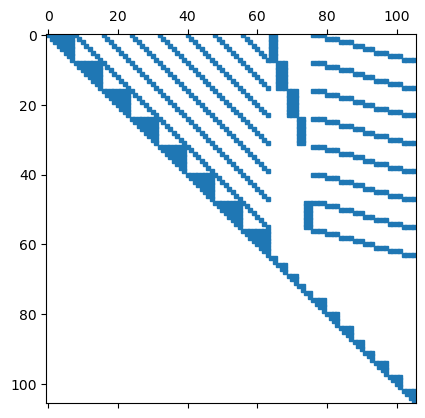

In [20]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.spy(A_tilde, markersize=3)